In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [5]:
# path_to_data is the folder for all input and output of SynTwin, replace path_to_data to your path
# Distance_matrices and Percolation_threshold subfolders were created in previous step
# Create a subfolder Vital_prediction for results in this file
path = 'path_to_data/'
data_path = 'path_to_data/Encoded_data' 
output_path = 'path_to_data/Vital_prediction'  

distance_folder ='Distance_matrices'
percolation_folder = 'Percolation_threshold'

In [3]:
# the threshold we selected based on the curve
def get_threshold(method):
    threshold_dict = {
        'euclidean': 2,
        'manhattan': 4,
        'cosine': 0.22,
        'gower': 0.12
    }
    return threshold_dict[method]

# the resolution we selected in previous step
def get_resolution(method):
    threshold_dict = {
        'euclidean': 250,
        'manhattan': 340,
        'cosine': 220,
        'gower': 1060
    }
    return threshold_dict[method]


def get_cdist_metric(method):
    metric_dict = {
        'euclidean': 'euclidean',
        'manhattan': 'cityblock',
        'cosine': 'cosine',
    }
    return metric_dict[method]    
    


from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# compute Precision, Recall, Accuracy, BalancedAccuracy, F1, AUROC, CM
def compute_performance(y_true, y_predict):
    y_predict_prob = y_predict
    y_predict = np.round(y_predict)
    Precision = round(precision_score(y_true=y_true, y_pred=y_predict), 4) 
    Recall = round(recall_score(y_true=y_true, y_pred=y_predict), 4)
    Accuracy = round(accuracy_score(y_true=y_true, y_pred=y_predict), 4)
    BalancedAccuracy = round(balanced_accuracy_score(y_true=y_true, y_pred=y_predict), 4)
    F1 = round(f1_score(y_true=y_true, y_pred=y_predict), 4)

    num_class = np.unique(np.array(y_true))
    if len(np.unique(np.array(y_true))) == 1:
        AUROC = np.nan
    else:
        AUROC = round(roc_auc_score(y_true=y_true, y_score=y_predict_prob), 4)
    CM = confusion_matrix(y_true=y_true, y_pred=y_predict)
    performance_list = [Precision, Recall, Accuracy, BalancedAccuracy, F1, AUROC, CM]
    return performance_list

# predict by mean/mode(knn) and return results
def predict_vitalstatus(y, feature, real_node):
    #count and std
    count=len(y)
    std = y.std()     
    dead = y.sum()
    ratio = dead / len(y)

    #predict by mean
    pred_label_mean = y.mean() 

    #predict by mode
    pred_label_mode = y.mode()[0]  

    #predict by knn
    X_train = feature
    y_train = y

    X_test = real_data[real_data['PatientID']==real_node].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}).values 
    y_test = real_data[real_data['PatientID']==real_node]['VitalStatus'].values
    
    knn = KNeighborsClassifier(n_neighbors=count)
    knn.fit(X_train, y_train)
    
    pred_label_knn = knn.predict(X_test)[0]
    
    #true label
    true_label = real_data[real_data['PatientID']==real_node]['VitalStatus'].item()
    
    #prediction_list = [count, std, pred_label_mean, pred_label_mode, pred_label_knn, true_label]
    
    return count, std, dead, ratio, pred_label_mean, pred_label_mode, pred_label_knn, true_label
    

In [6]:
import pandas as pd
import glob
import os

# 30k real data
real_data = pd.read_csv(data_path+'holdout_ohe.csv') 
real_data = real_data.drop(columns= ['Unnamed: 0'])

# 1M synthetic data
synthetic_data = pd.read_csv(data_path+ 'synth1M_ohe.csv')
synthetic_data = synthetic_data.rename(columns={'Unnamed: 0': 'PatientID'})

In [10]:
import pandas as pd
import igraph as ig
from igraph import Graph
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from ast import literal_eval
from step4b_cdist_gower import cdist_gower
    
s = 42

def main(method):
    print(method)
    
    #network of 30k holdout (within threshold)
    threshold=get_threshold(method) 
    random.seed(s)
    network = pd.read_csv(path+percolation_folder+'/cytoscape_'+method+str(threshold)+'.csv') 
    network.loc[:,'Obj1'] = network.loc[:,'Obj1'].astype(str)
    network.loc[:,'Obj2'] = network.loc[:,'Obj2'].astype(str)
    g = Graph.DataFrame(network, directed=False, use_vids=False)

    #weight
    network['Weights'] = 1 - network['Dist']/max(network['Dist'])
    g.es['weight'] = network['Weights']

    #multilevel (resolution=r to maximize 10memebers communities)
    r = get_resolution(method)
    print('resolution: '+str(r))
    random.seed(s)
    communities = g.community_multilevel(weights=network['Weights'], resolution=r) 

    #stats of number of communities (non-single, 10-memembers)
    num_nodes=0
    num_non_single_comm=0
    num_10members_comm=0

    for i in range(len(communities)):
        if len(communities[i])>1:
            num_non_single_comm+=1    

            if len(communities[i])>=10:
                num_10members_comm+=1
                num_nodes+=len(communities[i])  
    print(str(len(communities))+' communities')
    print(str(num_non_single_comm)+' non single communities')
    print(str(num_10members_comm)+' 10+ members communities')
    print(str(num_nodes)+' nodes in 10+ members communities')

    #read distance matrix
    #with open(path+distance_folder+'/'+ method + '_real_real.pkl', "rb") as input_file:
    #    real_real = pickle.load(input_file)
    input_file = path+distance_folder+'/'+ method + '_real_real.pkl'
    real_real = pd.read_pickle(input_file)
    
    community_centers = []
    community_member_lists = []
    community_distances = []
    community_info =[]

    n_communities_10 = 0
    #for each community with >=10 memebers, get the center, list of members, distance from each member to center, num of dead patients
    for subgraph in communities.subgraphs():
        if subgraph.vcount()>=10:
            random.seed(s)
            cents = subgraph.eigenvector_centrality() 
            max_idx = np.argmax(cents)
            community_center = subgraph.vs[max_idx]['name'] 
            community_centers.append(community_center)

            community_members = [literal_eval(mem) for mem in subgraph.vs['name']]
            community_member_lists.append(community_members)

            dist_real = real_real.loc[community_members, int(community_center)].to_list()
            community_distance = max(dist_real)
            community_distances.append(community_distance)

            vital_real = real_data.loc[real_data['PatientID'].isin(community_members), 'VitalStatus']

            dead_patient = vital_real.sum() 

            dead_ratio = dead_patient / len(community_members)

            n_communities_10+=1

            community_info.append([n_communities_10, len(community_members), dead_patient, dead_ratio, community_distance, community_center])       
                
    cols = ['n_communities_10', 'num_patients', 'dead_patient', 'dead_ratio', 'community_distance', 'community_center']
    community_info_df = pd.DataFrame(community_info, columns=cols)
    community_info_df.to_csv(output_path+method+'_community_info.csv', index=False)

    del real_real

    synth = synthetic_data.drop(columns = ['PatientID','SurvivalMonths','VitalStatus']) 
    synth_ids = synthetic_data['PatientID']
    real =  real_data.drop(columns = ['SurvivalMonths','VitalStatus']) 
    
    # read label encoded data
    if method =='gower':
        real_le = pd.read_csv(data_path+'holdout_le.csv') 
        real_le = real_le.drop(columns= ['Unnamed: 0','SurvivalMonths','VitalStatus'])            

        synth_le = pd.read_csv(data_path+ 'synth1M_le.csv')         
        synth_le = synth_le.drop(columns = ['Unnamed: 0','SurvivalMonths','VitalStatus']) 
        synth_le_pt = pd.read_csv(data_path+ 'synth1M_le.csv')  

    # the code below named prediction function slightly different from paper
    predic_function_a =[]
    predic_function_b =[]
    predic_function_bn =[]
    predic_function_c =[]   
    predic_function_cn =[]
    predic_function_d =[]
    performances=[]

    for i in range(n_communities_10):

        community_id = i+1

        # calculate the distance between center and synthetic patients 
        if method =='gower': 
            center = real_le[real_le['PatientID']==int(community_centers[i])].drop(columns=['PatientID'])  
            random.seed(s)
            synth_temp = pd.DataFrame(cdist_gower(center, synth_le.iloc[:,0:], cat_features = [False, False, False, True, True, False, True, False, True, True, True, False], num_ranges=[14, 5, 1, 8, 99, 8]), columns=synth_ids)
        else:
            cdist_metric = get_cdist_metric(method)
            random.seed(s)
            synth_temp = pd.DataFrame(cdist(real[real['PatientID']==int(community_centers[i])].drop(columns=['PatientID']), synth.iloc[:,0:], metric=cdist_metric), columns=synth_ids)

        # filter synthetic patients to those within the community (distance to center less than max distance )
        synth_community_members = synth_temp.columns[synth_temp.iloc[0].lt(community_distances[i])].tolist()

        # for each real patient in the community, predict vital status with the six prediction functions (the names of prediction functions are slightly different from paper)
        for j in range(len(community_member_lists[i])):        
            real_node = community_member_lists[i][j]

            #a (real patients)
            comm_id = community_member_lists[i]
            a_id = [x for x in comm_id if x != real_node] # get rid of itself in the list
            real_label = real_data.loc[real_data['PatientID'].isin(a_id), 'VitalStatus']
            real_feature = real_data[real_data['PatientID'].isin(a_id)].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}).values

            count_a, std_a, dead_a, ratio_a, pred_label_mean_a, pred_label_mode_a, pred_label_knn_a, true_label = predict_vitalstatus(real_label, real_feature, real_node)        
            predic_function_a.append([community_id, real_node, method, 'real', count_a, std_a, dead_a, ratio_a, pred_label_mean_a, pred_label_mode_a, pred_label_knn_a, true_label])

            #b (digital twins)
            b_id = synth_community_members
            synth_label = synthetic_data.loc[synthetic_data['PatientID'].isin(b_id), 'VitalStatus']
            synth_feature = synthetic_data[synthetic_data['PatientID'].isin(b_id)].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}).values

            count_b, std_b, dead_b, ratio_b, pred_label_mean_b, pred_label_mode_b, pred_label_knn_b, true_label = predict_vitalstatus(synth_label, synth_feature, real_node)        
            predic_function_b.append([community_id, real_node, method, 'synth', count_b, std_b, dead_b, ratio_b, pred_label_mean_b, pred_label_mode_b, pred_label_knn_b, true_label])

            #b top n (the closest digital twins )
            if method =='gower': 
                real_node_le = real_le[real_le['PatientID']==int(real_node)].drop(columns=['PatientID'])  
                synth_community_members_le = synth_le_pt[synth_le_pt['Unnamed: 0'].isin(synth_community_members)].drop(columns={'Unnamed: 0', 'VitalStatus', 'SurvivalMonths'})
                random.seed(s)
                synth_to_real_node = pd.DataFrame(cdist_gower(real_node_le, synth_community_members_le, cat_features = [False, False, False, True, True, False, True, False, True, True, True, False], num_ranges=[14, 5, 1, 8, 99, 8]), columns=synth_community_members)
            else:
                random.seed(s)
                synth_to_real_node = pd.DataFrame(cdist(real[real['PatientID']==int(real_node)].drop(columns=['PatientID']), synthetic_data[synthetic_data['PatientID'].isin(synth_community_members)].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}), metric=cdist_metric), columns=synth_community_members)
            btopn_id = synth_to_real_node.loc[0].nsmallest(n=len(a_id)-1, keep='all').index.tolist()
            synthn_label = synthetic_data.loc[synthetic_data['PatientID'].isin(btopn_id), 'VitalStatus']
            synthn_feature = synthetic_data[synthetic_data['PatientID'].isin(btopn_id)].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}).values

            count_bn, std_bn, dead_bn, ratio_bn, pred_label_mean_bn, pred_label_mode_bn, pred_label_knn_bn, true_label = predict_vitalstatus(synthn_label, synthn_feature, real_node)        
            predic_function_bn.append([community_id, real_node, method, 'synth_topn', count_bn, std_bn, dead_bn, ratio_bn, pred_label_mean_bn, pred_label_mode_bn, pred_label_knn_bn, true_label])
            
            #c (real patients and digital twins)
            all_label = pd.concat([real_label, synth_label]) #np.concatenate((real_label.values, synth_label.values), axis=0)
            all_feature = np.concatenate((real_feature, synth_feature), axis=0)

            count_c, std_c, dead_c, ratio_c, pred_label_mean_c, pred_label_mode_c, pred_label_knn_c, true_label = predict_vitalstatus(all_label, all_feature, real_node)        
            predic_function_c.append([community_id, real_node, method, 'real+synth', count_c, std_c, dead_c, ratio_c, pred_label_mean_c, pred_label_mode_c, pred_label_knn_c, true_label])

            #c top n (real patients and closest digital twins)
            alln_label = pd.concat([real_label, synthn_label]) 
            alln_feature = np.concatenate((real_feature, synthn_feature), axis=0)

            count_cn, std_cn, dead_cn, ratio_cn, pred_label_mean_cn, pred_label_mode_cn, pred_label_knn_cn, true_label = predict_vitalstatus(alln_label, alln_feature, real_node)        
            predic_function_cn.append([community_id, real_node, method, 'real+synth_topn', count_cn, std_cn, dead_cn, ratio_cn, pred_label_mean_cn, pred_label_mode_cn, pred_label_knn_cn, true_label])

            #d (real patients outside the community)
            real_id = real_data['PatientID']
            res_id = [i for i in real_id if i not in comm_id]
            random.seed(s)
            d_id = random.sample(res_id, len(community_member_lists[i])-1) 
            outer_label = real_data.loc[real_data['PatientID'].isin(d_id), 'VitalStatus']
            outer_feature = real_data[real_data['PatientID'].isin(d_id)].drop(columns={'PatientID', 'VitalStatus', 'SurvivalMonths'}).values

            count_d, std_d, dead_d, ratio_d, pred_label_mean_d, pred_label_mode_d, pred_label_knn_d, true_label = predict_vitalstatus(outer_label, outer_feature, real_node)        
            predic_function_d.append([community_id, real_node, method, 'real_OC', count_d, std_d, dead_d, ratio_d, pred_label_mean_d, pred_label_mode_d, pred_label_knn_d, true_label])

    # save all predict results
    cols =['CommunityId', 'Real_Node', 'Method', 'Dataset', 'count', 'std', 'dead', 'ratio','mean', 'mode','knn', 'Real_VitalStatus']
    predic_function_a_df= pd.DataFrame(predic_function_a, columns=cols)
    predic_function_b_df= pd.DataFrame(predic_function_b, columns=cols)
    predic_function_bn_df= pd.DataFrame(predic_function_bn, columns=cols)
    predic_function_c_df= pd.DataFrame(predic_function_c, columns=cols)
    predic_function_cn_df= pd.DataFrame(predic_function_cn, columns=cols)
    predic_function_d_df= pd.DataFrame(predic_function_d, columns=cols)

    all_predict= pd.concat([predic_function_a_df, predic_function_b_df, predic_function_bn_df, predic_function_c_df, predic_function_cn_df, predic_function_d_df])
    all_predict= all_predict.set_index(['Real_Node','Method','Dataset'])
    all_predict.to_csv(output_path+method+'_all_predict.csv')


In [11]:
from datetime import datetime
datetime.now()

main('euclidean')

datetime.now()

datetime.datetime(2023, 9, 28, 10, 9, 25, 187475)

euclidean
resolution: 250
11754 communities
1381 non single communities
559 10+ members communities
16131 nodes in 10+ members communities


datetime.datetime(2023, 9, 28, 11, 18, 18, 174497)

In [13]:
main('manhattan')

manhattan
resolution: 340
13963 communities
1277 non single communities
508 10+ members communities
13995 nodes in 10+ members communities


In [14]:
main('cosine')

cosine
resolution: 220
15286 communities
1243 non single communities
529 10+ members communities
13023 nodes in 10+ members communities


In [15]:
main('gower')

gower
resolution: 1060
18493 communities
1121 non single communities
393 10+ members communities
9619 nodes in 10+ members communities


### Overall Performances

In [12]:
import pandas as pd

datasets  = ['real','synth','synth_topn','real+synth','real+synth_topn','real_OC']
predict_functions = ['mean','mode','knn']
method_list = ['euclidean','manhattan','cosine','gower']

overall_performances= []
for method in method_list:
    all_predict = pd.read_csv(output_path+method+'_all_predict.csv')
    for dataset in datasets:
        all_df = all_predict[(all_predict['Dataset']==dataset)]
        for predict_function in predict_functions:
            cols_to_select = [col for col in all_predict.columns if predict_function in col]
            cols_to_select.append('Real_VitalStatus')
            df = all_df[cols_to_select]

            y_true = df['Real_VitalStatus']
            y_pred = df[predict_function]

            overall_performance_list = compute_performance(y_true=y_true, y_predict=y_pred)
            overall_performance = [method, dataset, predict_function]
            overall_performance.extend(overall_performance_list)
            overall_performances.append(overall_performance) 

cols = ['Method', 'Dataset', 'PredictionFunction', 'Precision', 'Recall', 'Accuracy', 'BalancedAccuracy','F1', 'AUROC', 'CM']
overall_performances_df= pd.DataFrame(overall_performances, columns=cols)
overall_performances_df.to_csv(output_path+'overall_performances.csv',index=False)


### 90% Population Bootstrap

In [2]:
datasets  = ['real','synth','real+synth','synth_topn','real+synth_topn','real_OC']
predict_functions = ['mean','mode','knn']

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
import pandas as pd
from tqdm import tqdm
import numpy as np

# boorstrap 1000 times, each time sample 90% population
def bootstrap_resample_90perc_performance(method):
    all_predict = pd.read_csv(output_path+method+'_all_predict.csv')
    pt_id = pd.DataFrame(all_predict['Real_Node'].unique())#.tolist()
    n = round(0.9 * len(pt_id))    
    total_patient = len(pt_id)

    performances =[]
    
    for seed in tqdm(range(1000)): 
        for dataset in datasets:
            all_df = all_predict[(all_predict['Dataset']==dataset)]

            # for each predict function, sample 90% population & associated results
            for predict_function in predict_functions:

                cols_to_select = [col for col in all_predict.columns if predict_function in col]
                cols_to_select.extend(['Real_VitalStatus', 'Real_Node'])
                df = all_df[cols_to_select]
                sub_df = resample(df, n_samples=n, random_state=seed) 

                num_patient = len(sub_df['Real_Node'])
                num_unique_patient = len(sub_df['Real_Node'].unique())

                y_true = sub_df['Real_VitalStatus']
                y_pred = sub_df[predict_function]

                # calculate performance 
                performance_list = compute_performance(y_true=y_true, y_predict=y_pred)
                performance = [method, seed, total_patient, num_patient, num_unique_patient, dataset, predict_function]
                performance.extend(performance_list)
                performances.append(performance) 

    #save results
    cols = ['Method', 'SamplingRandomState', 'TotalNumPatient', 'SamplingNumPatient', 'SamplingNumUniquePatient', 'Dataset', 'PredictionFunction', 'Precision', 'Recall', 'Accuracy', 'BalancedAccuracy','F1', 'AUROC', 'CM']
    performances_df= pd.DataFrame(performances, columns=cols)
    performances_df.to_csv(output_path+method+'_90perc_performances.csv',index=False)
    
    return performances_df


In [4]:
import pylab as pl
# show distribution 
def show_metric_dist(performances_df, method, predict_function, dataset):
    subset = performances_df[(performances_df['Dataset']==dataset)&(performances_df['PredictionFunction']==predict_function)]
    fig, axis = plt.subplots(2, 3, figsize=(15,7))
    subset.hist(column=['Accuracy', 'BalancedAccuracy', 'AUROC', 'Precision', 'Recall', 'F1'], ax=axis) #bins=40
    plt.suptitle('Sampling Dist -'+' (Distance method: '+method+', Dataset: '+dataset+', Prediction function: '+predict_function+')')
    plt.tight_layout()
    # create a subfolder 90perc bootstrap performance inside Vital_prediction for the plots
    plt.savefig(output_path+'90perc bootstrap performance/'+method+'_samplingdist_'+predict_function+'_'+dataset+'.png')
    plt.show()

import math
# calculate CI    
def get_ci(metric_result):
    m = metric_result.mean()
    c = metric_result.count()
    s = metric_result.std()

    ci95_hi = m + 1.96*s 
    ci95_lo = m - 1.96*s 
    
    return round(m,4), round(ci95_lo,4), round(ci95_hi,4)


metric_list = ['Accuracy', 'BalancedAccuracy', 'AUROC', 'Precision', 'Recall', 'F1']
# save CI to csv file
def summarize_ci(performances_df, level):
    ci =[]
    for predict_function in predict_functions:
        for dataset in datasets:
            all_df = performances_df[(performances_df['Dataset']==dataset)&(performances_df['PredictionFunction']==predict_function)]
            for metric in metric_list:
                metric_result = all_df[metric] 
                mean_value, ci95_low, ci95_high = get_ci(metric_result)
                ci.append([method, dataset, predict_function, metric, mean_value, ci95_low, ci95_high])
    cols =['Method', 'Dataset', 'PredictionFunction', 'Metric', 'mean', 'ci95_low', 'ci95_high']
    ci_df =pd.DataFrame(ci, columns=cols)
    ci_df.to_csv(output_path+method+'_'+level+'_ci.csv',index=False) #90perc, #commlevel
    return ci_df


import matplotlib.pyplot as plt
# plot CI
def plot_ci_all(ci_df, level):
    for predict_function in predict_functions:
        fig, axes = plt.subplots(2, 3, figsize = (15,10)) 
        
        for ax, metric in zip(axes.ravel(), metric_list):          
            ci_subset = ci_df[(ci_df['Metric']==metric)&(ci_df['PredictionFunction']==predict_function)]
                       
            for n in range(len(datasets)):
                horizontal_line_width = 0.25
                color = '#2187bb'
                ci = ci_subset[ci_subset['Dataset']==datasets[n]]
                x = n+1
                
                left = x - horizontal_line_width / 2
                top = ci['ci95_high']
                right = x + horizontal_line_width / 2
                bottom = ci['ci95_low']
                ax.plot([x, x], [top, bottom], color=color) 
                ax.plot([left, right], [top, top], color=color)
                ax.plot([left, right], [bottom, bottom], color=color)
                ax.plot(x, ci['mean'], 'o', color='#f44336')
    
                ax.set_title(metric)
                ax.set_xticks([1, 2, 3, 4, 5, 6], datasets) 
                ax.tick_params(labelsize =6) 
 
        plt.suptitle('Confidence Interval -'+' (Distance method: '+method+', Prediction function: '+predict_function+')')
        plt.tight_layout()
        # create a subfolder 90perc bootstrap performance inside Vital_prediction for the plots
        plt.savefig(output_path+level+' bootstrap performance/'+method+'_ci_'+predict_function+'.png')
        plt.show()

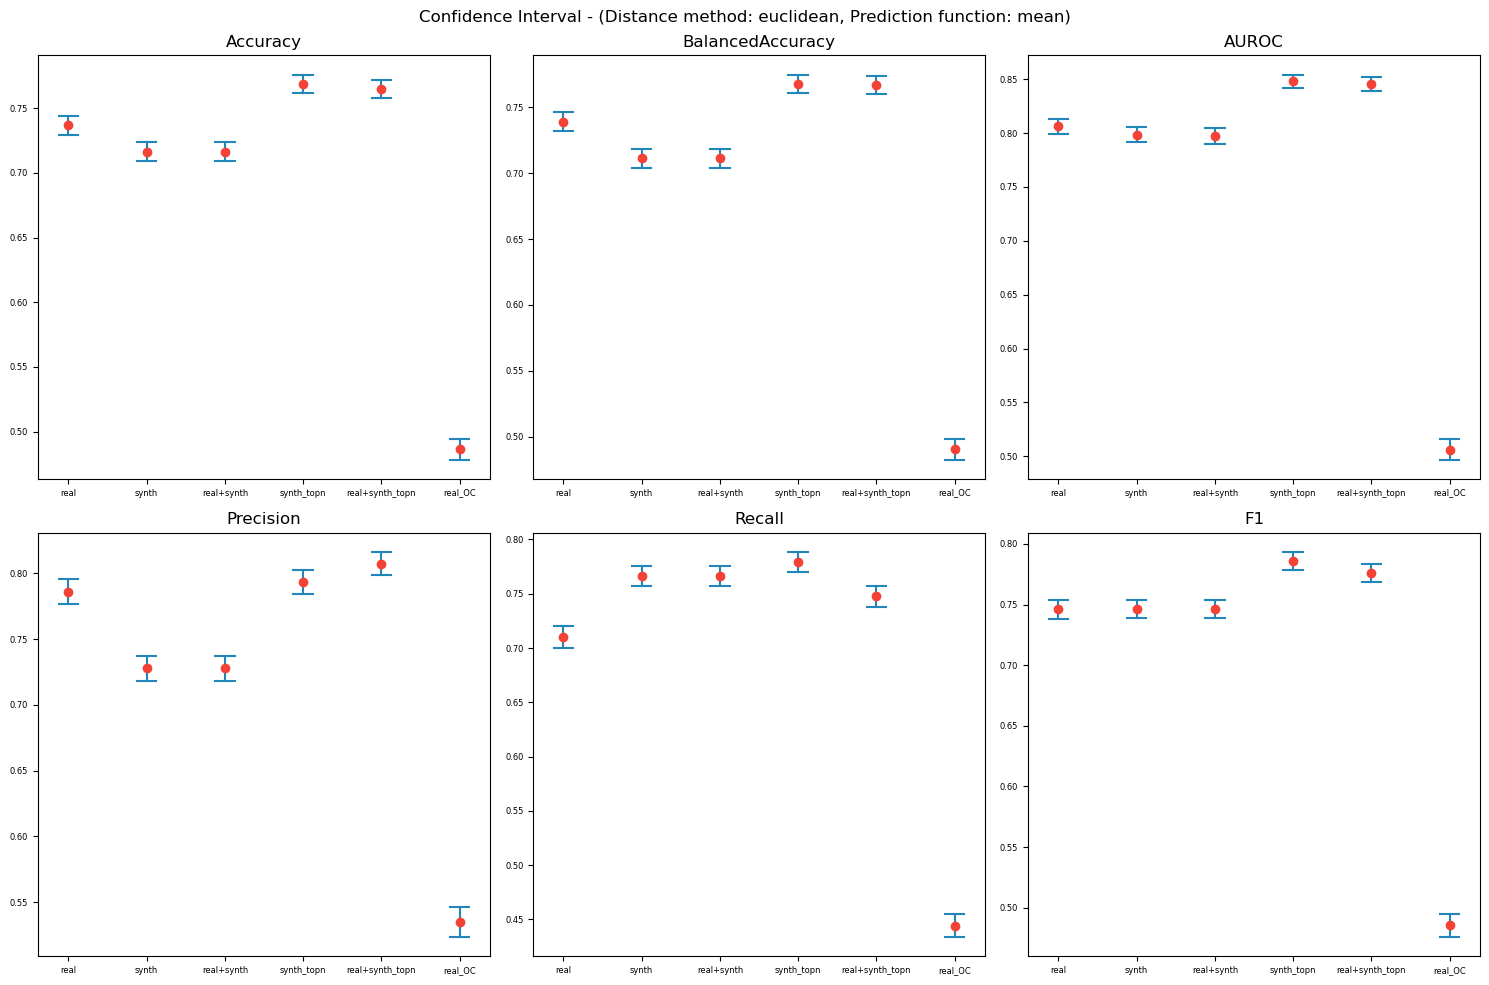

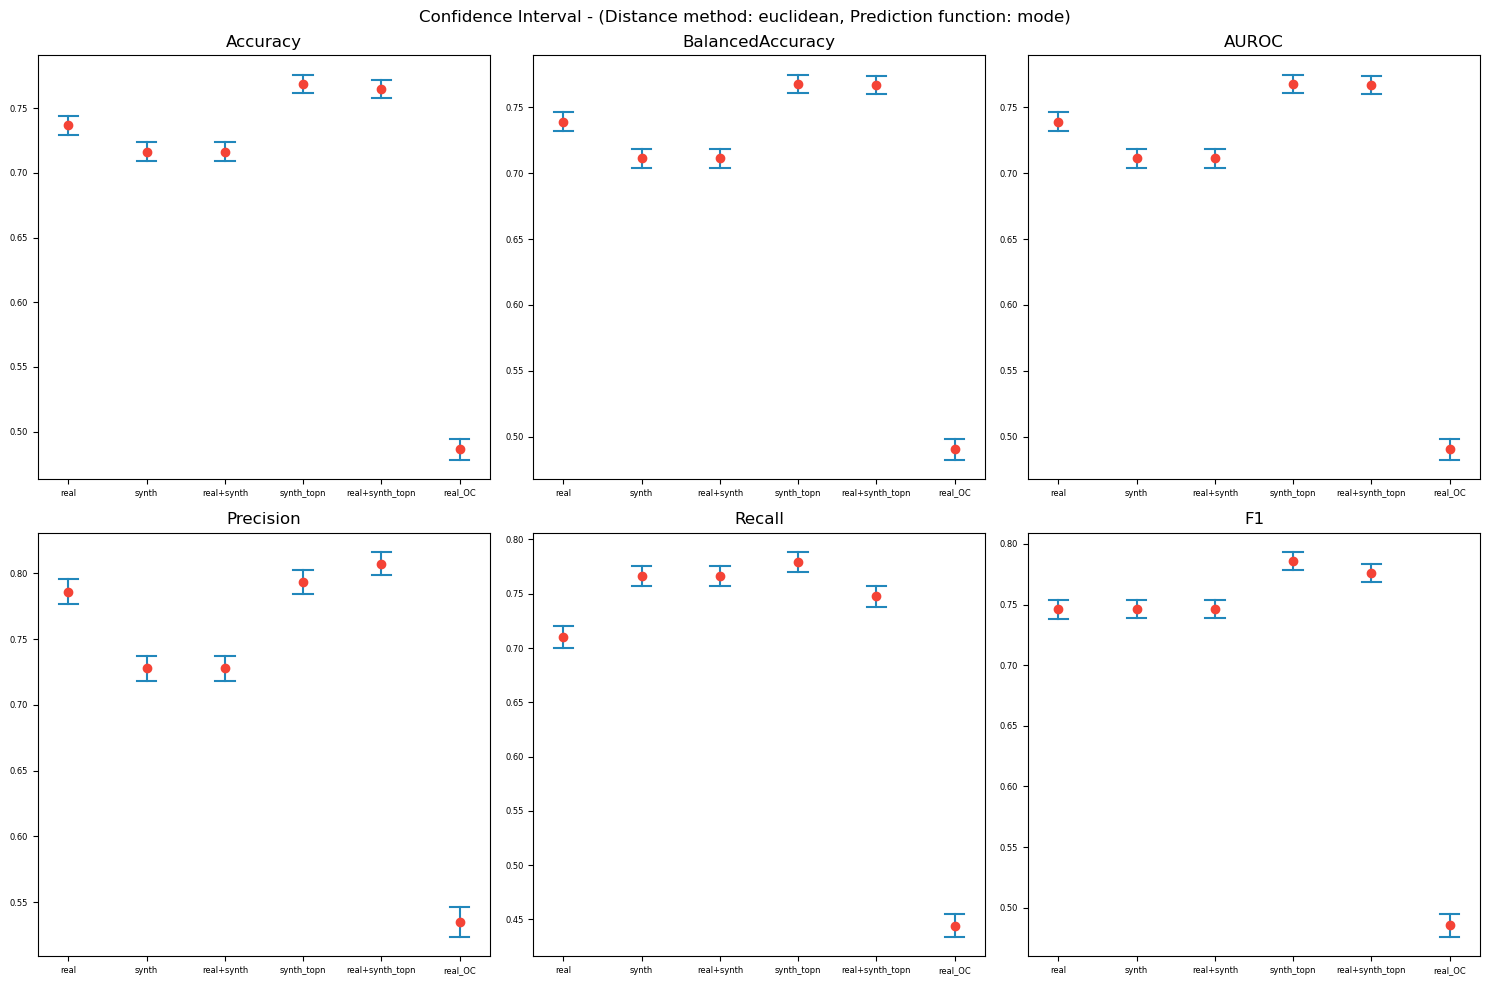

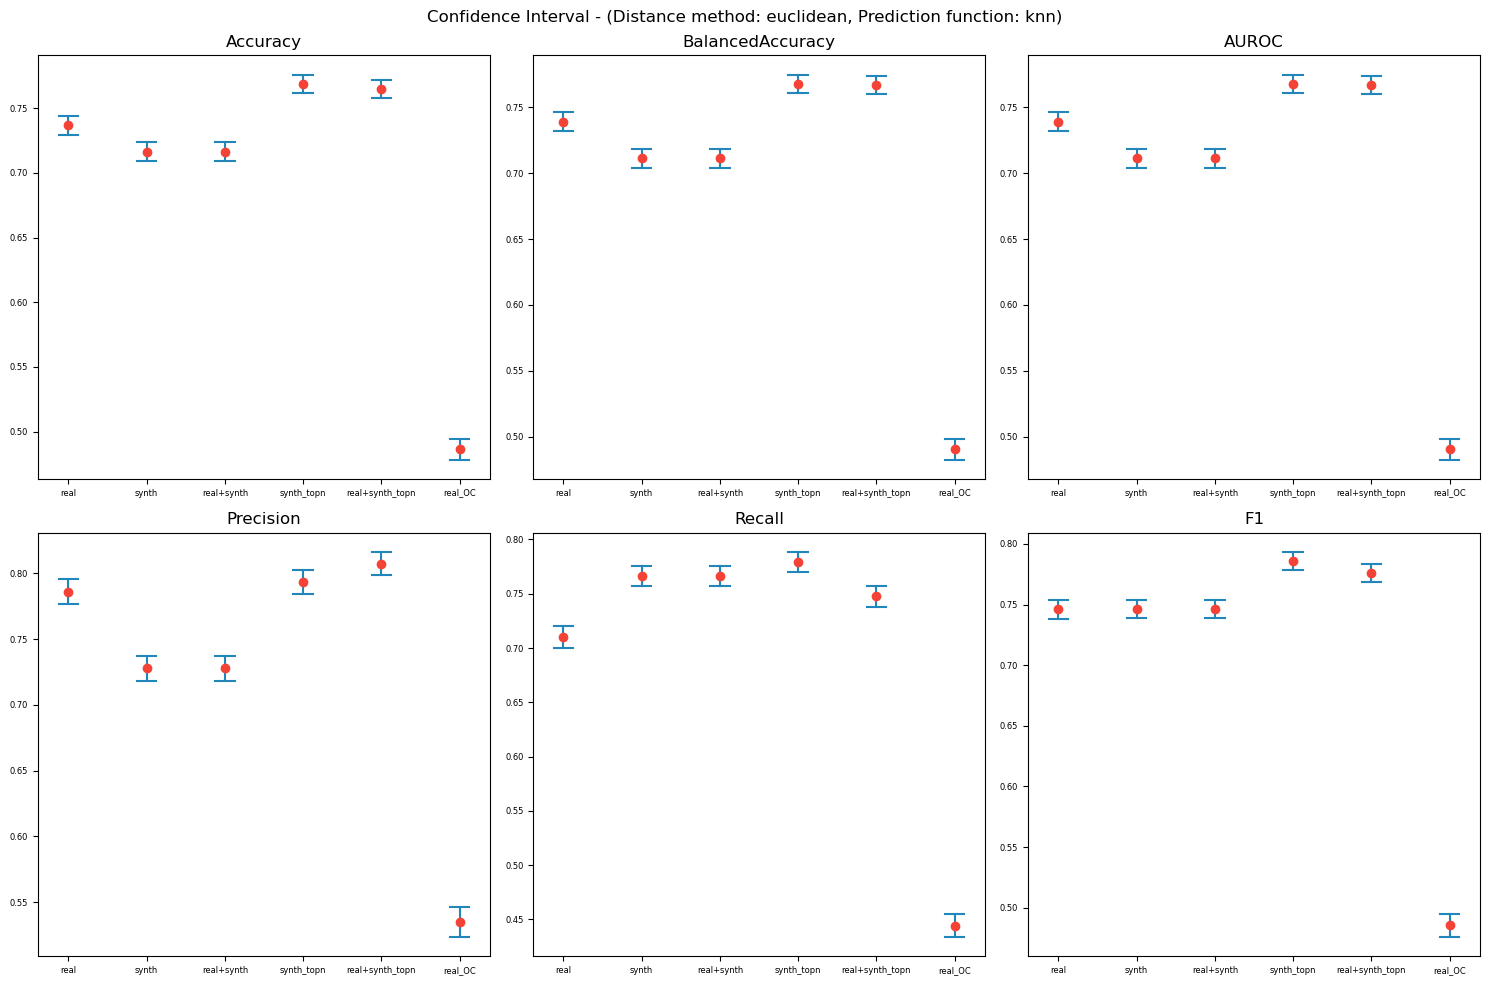

In [4]:
method ='euclidean'

import pandas as pd
performances_df = bootstrap_resample_90perc_performance(method) #or use performances_df=pd.read_csv(output_path+method+'_90perc_performances.csv')
ci_df = summarize_ci(performances_df, '90perc')
plot_ci_all(ci_df, '90perc')

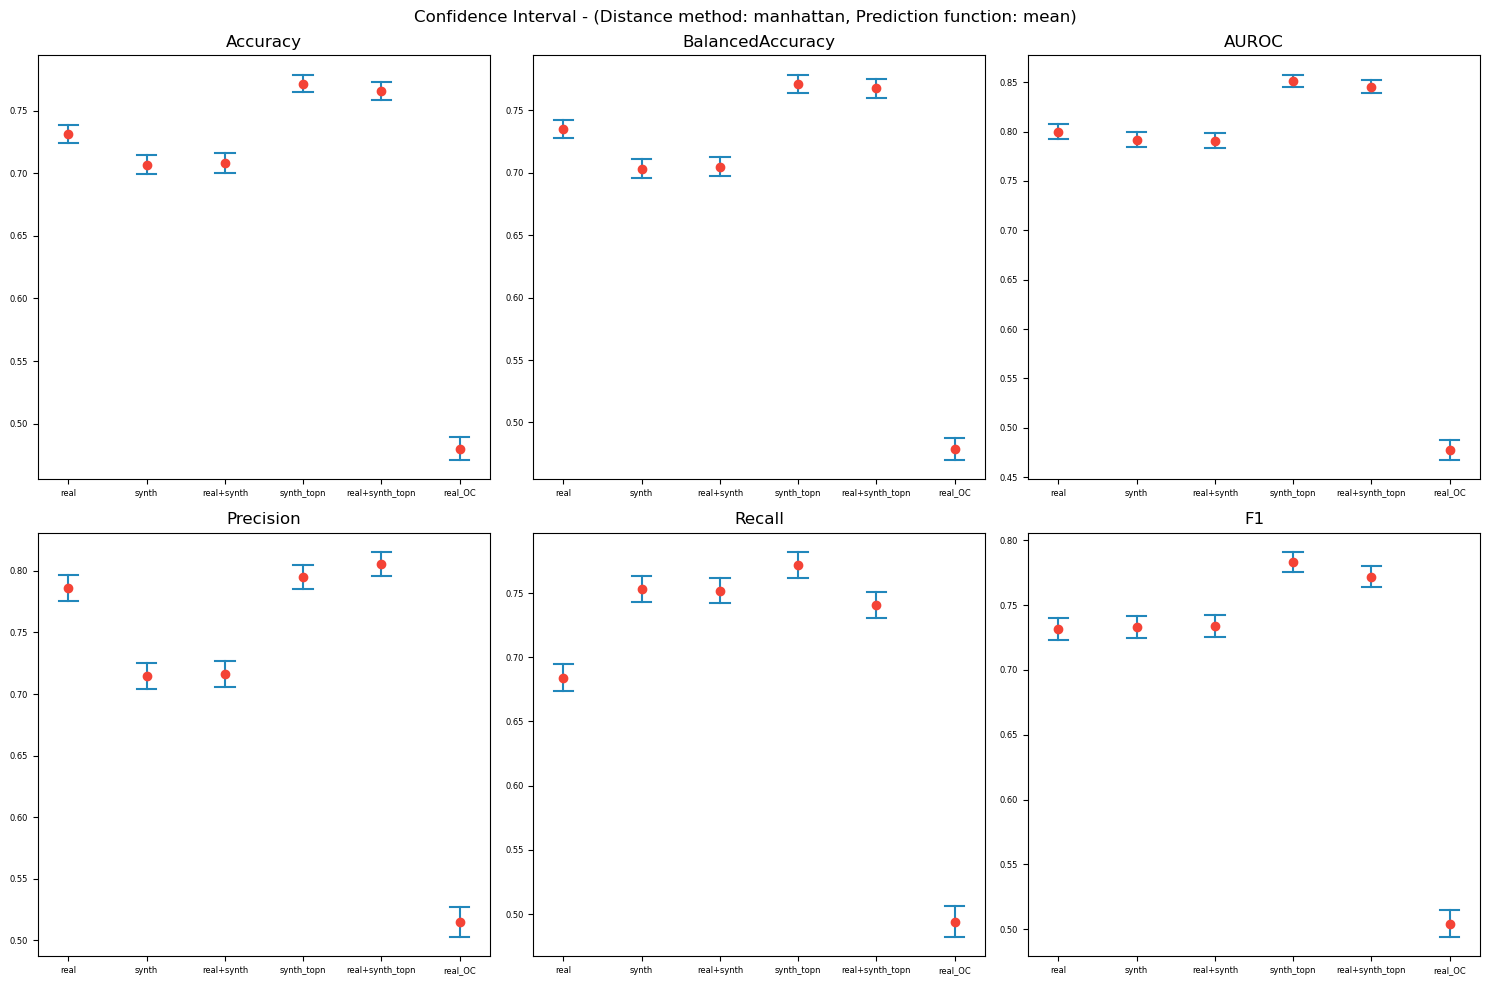

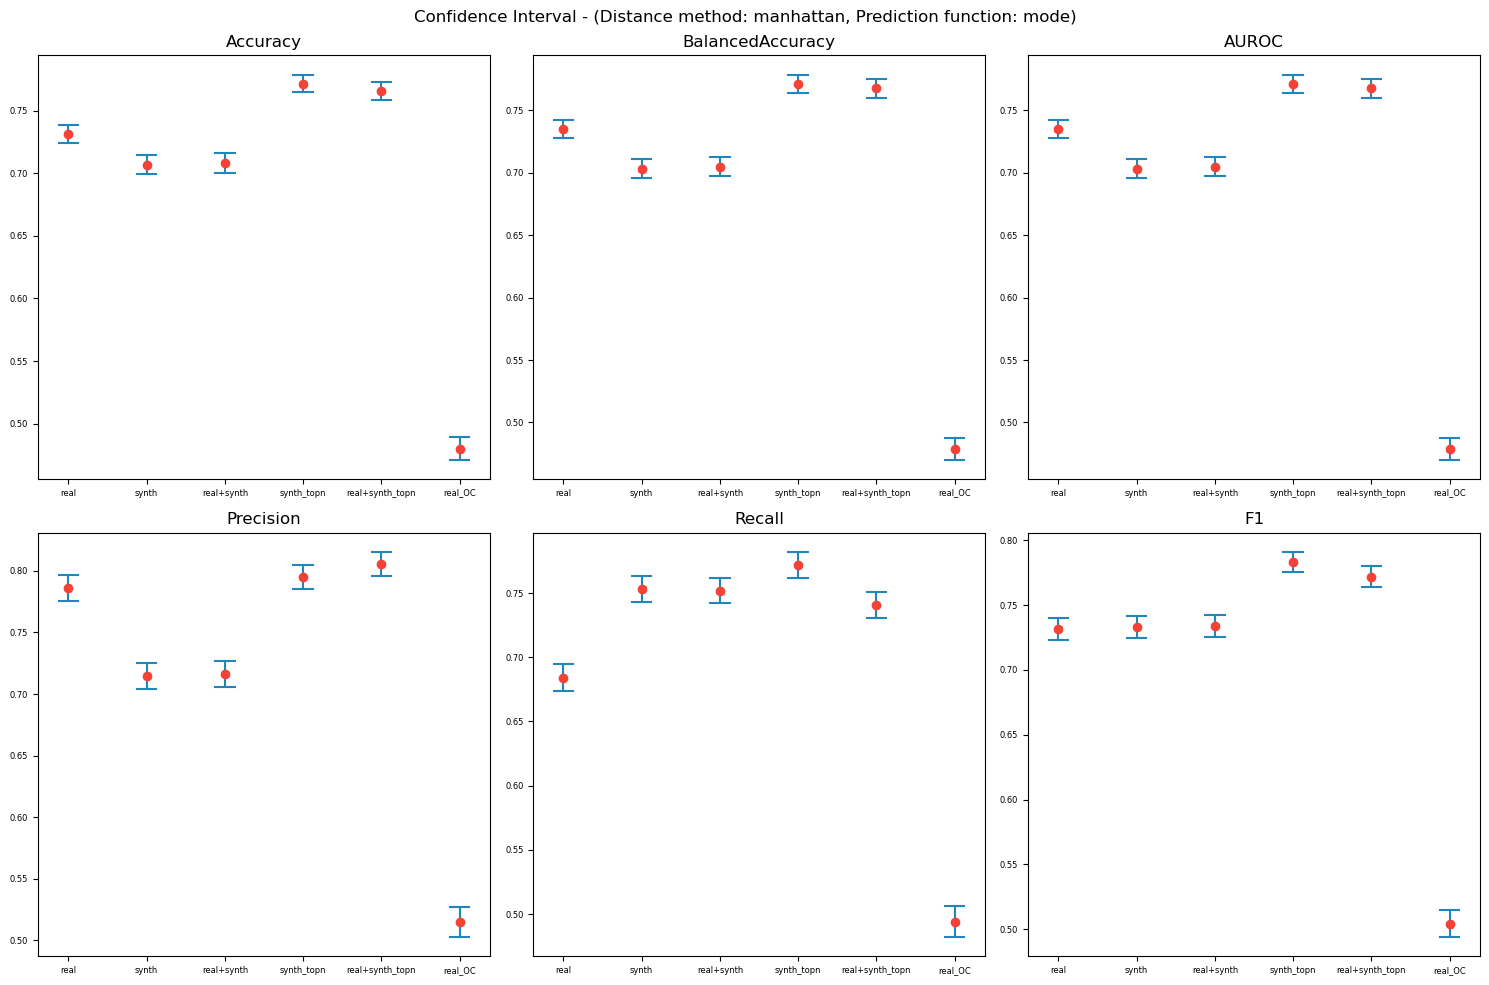

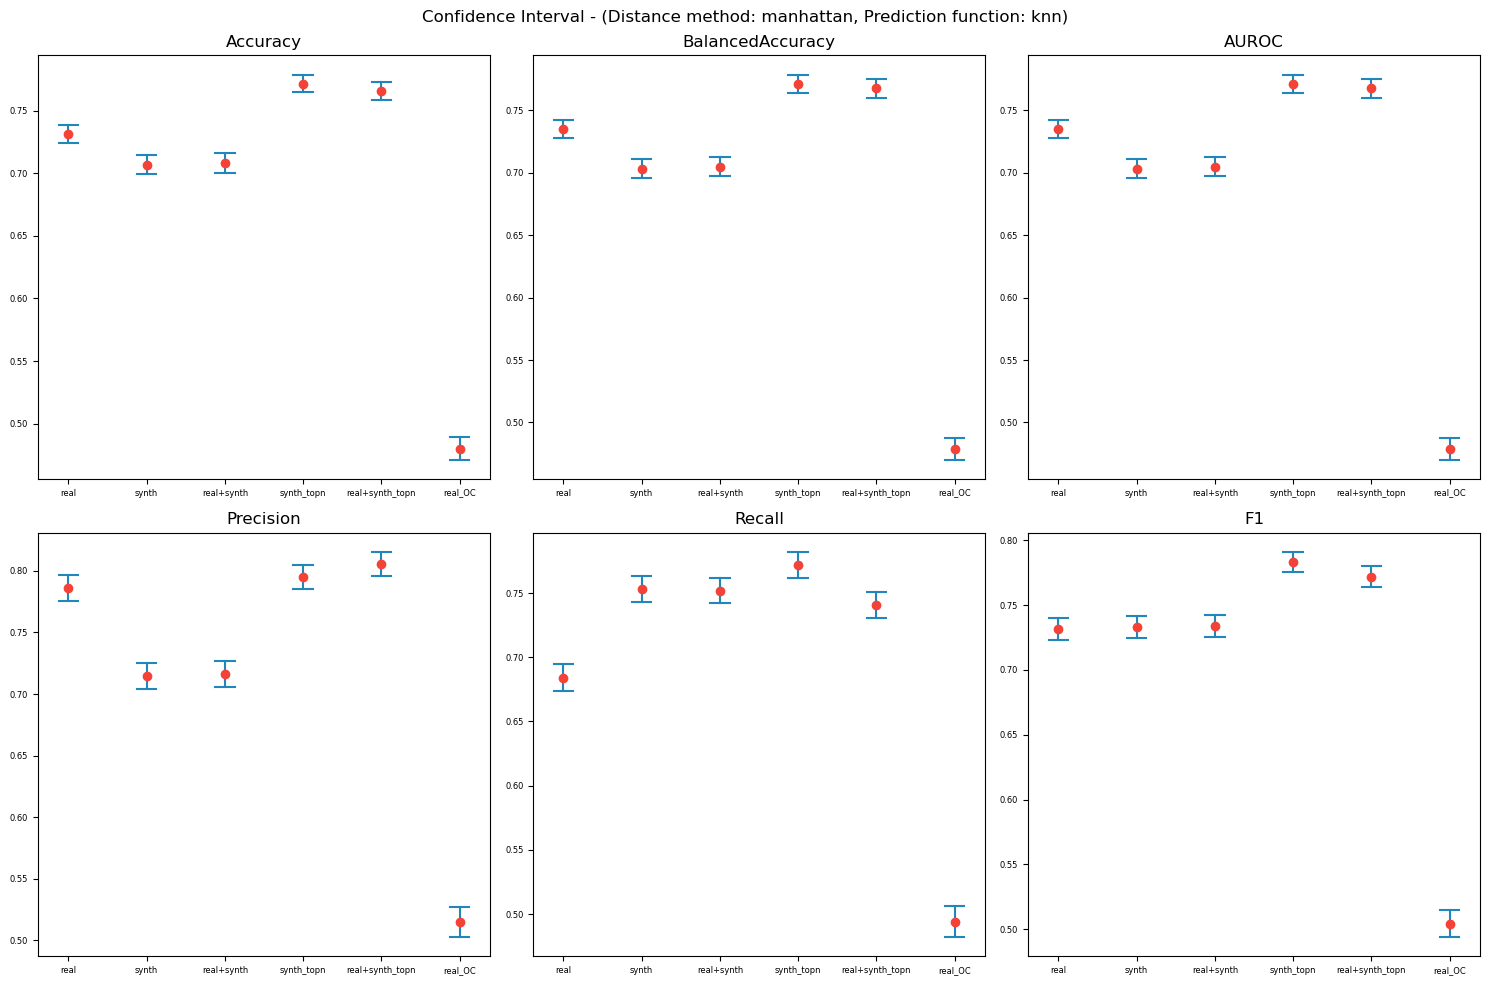

In [5]:
method ='manhattan'

import pandas as pd
performances_df = bootstrap_resample_90perc_performance(method) #or use performances_df=pd.read_csv(output_path+method+'_90perc_performances.csv')
ci_df = summarize_ci(performances_df, '90perc')
plot_ci_all(ci_df, '90perc')

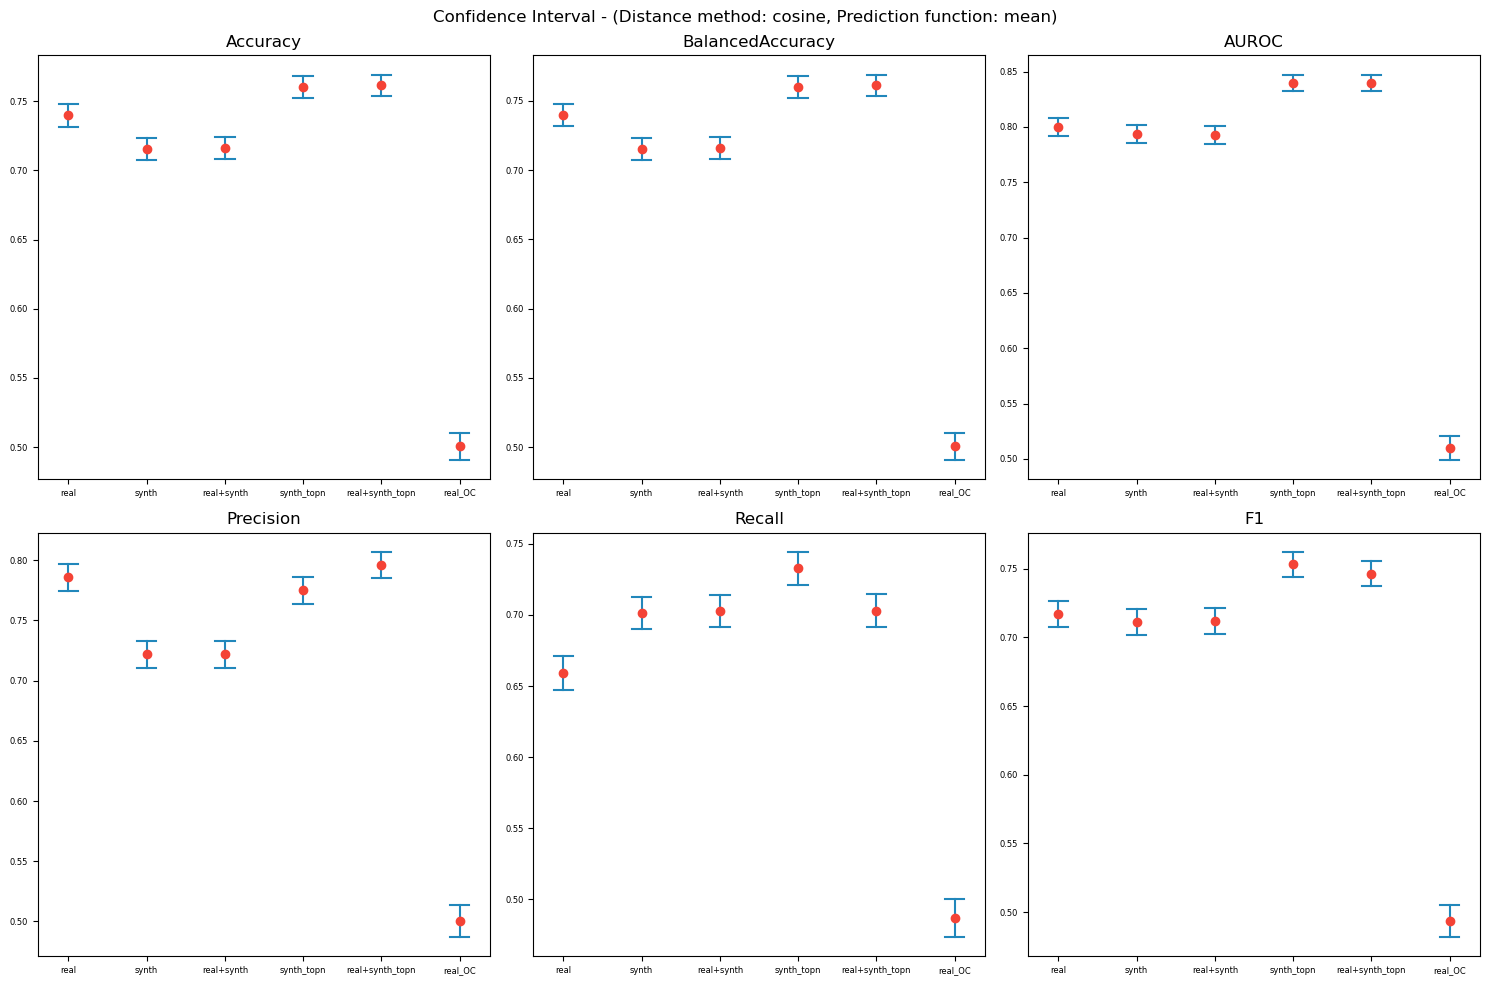

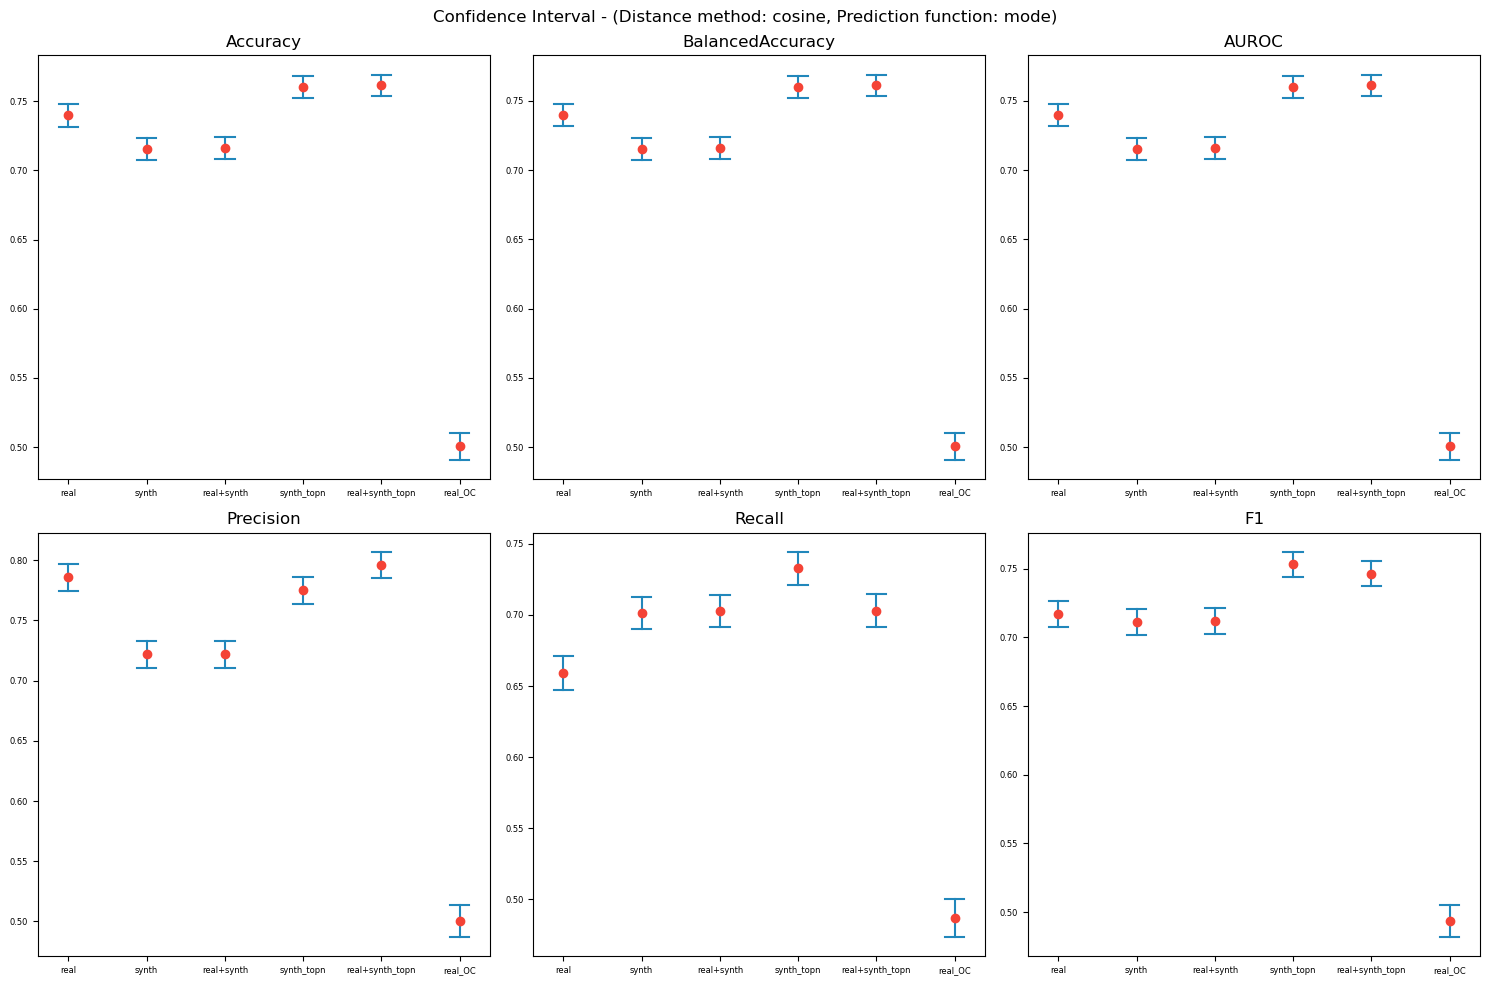

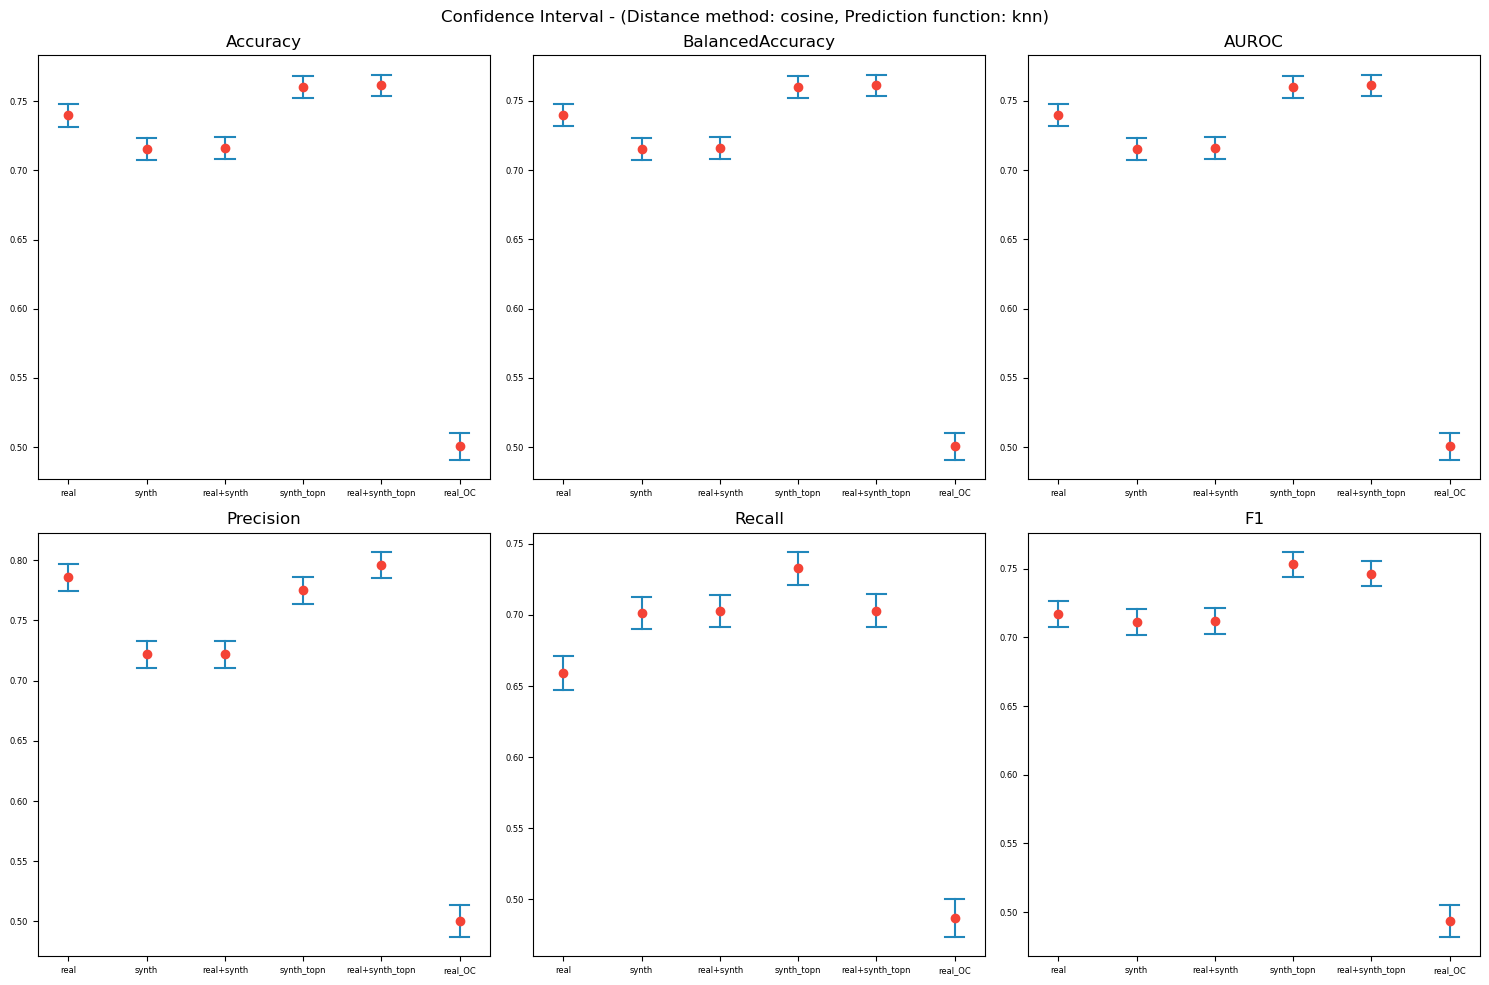

In [6]:
method ='cosine'

import pandas as pd
performances_df = bootstrap_resample_90perc_performance(method) #or use performances_df=pd.read_csv(output_path+method+'_90perc_performances.csv')
ci_df = summarize_ci(performances_df, '90perc')
plot_ci_all(ci_df, '90perc')


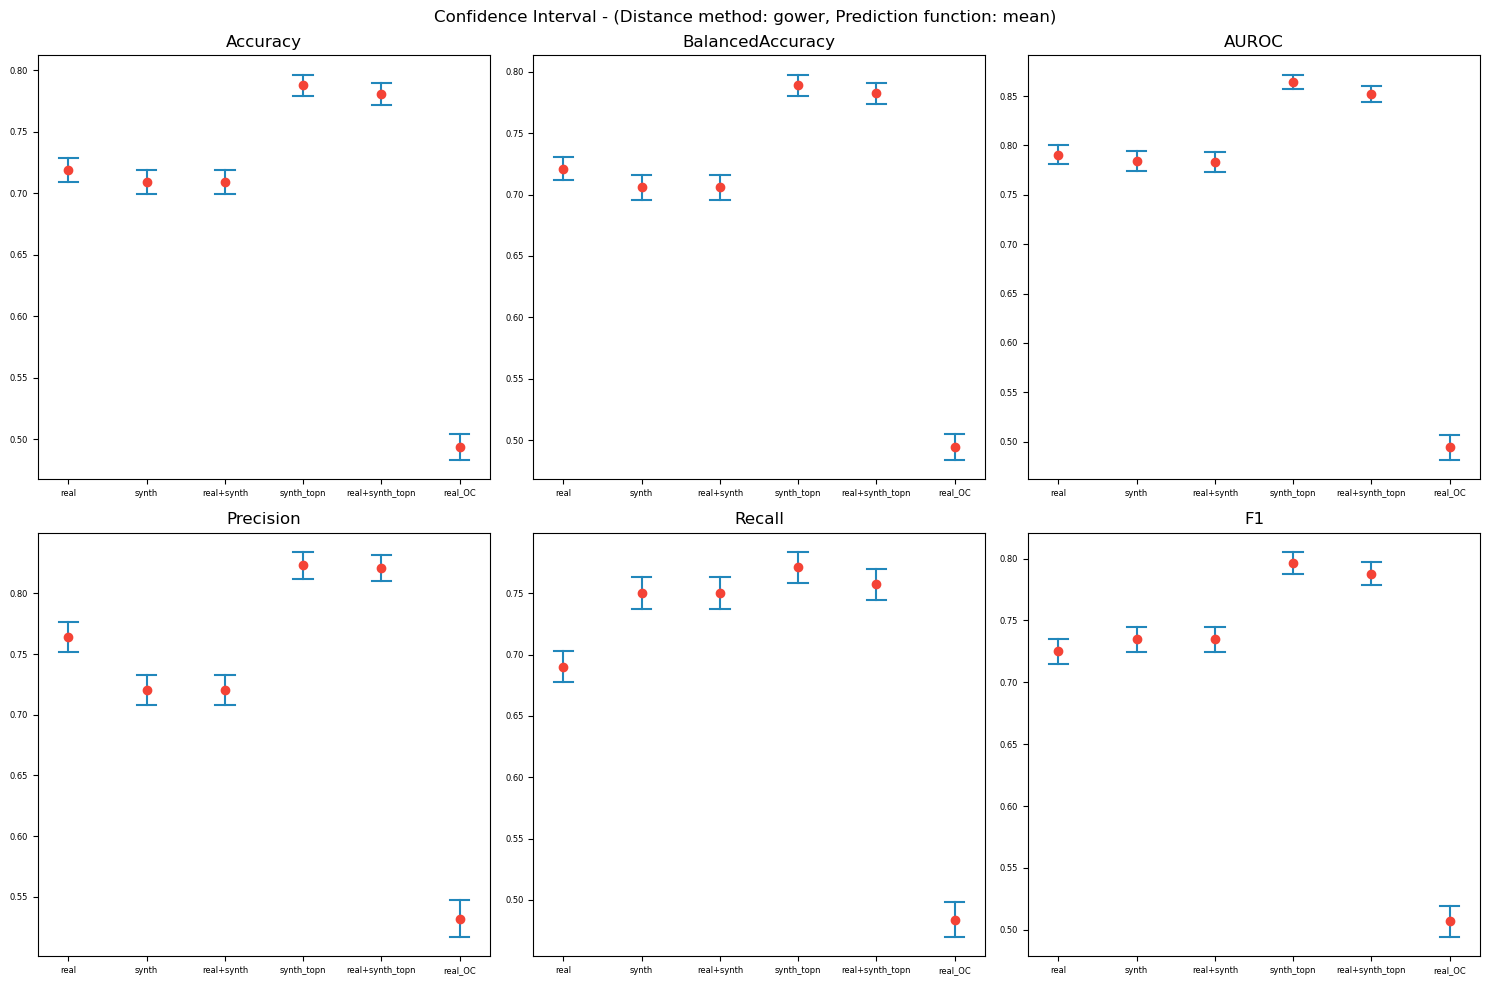

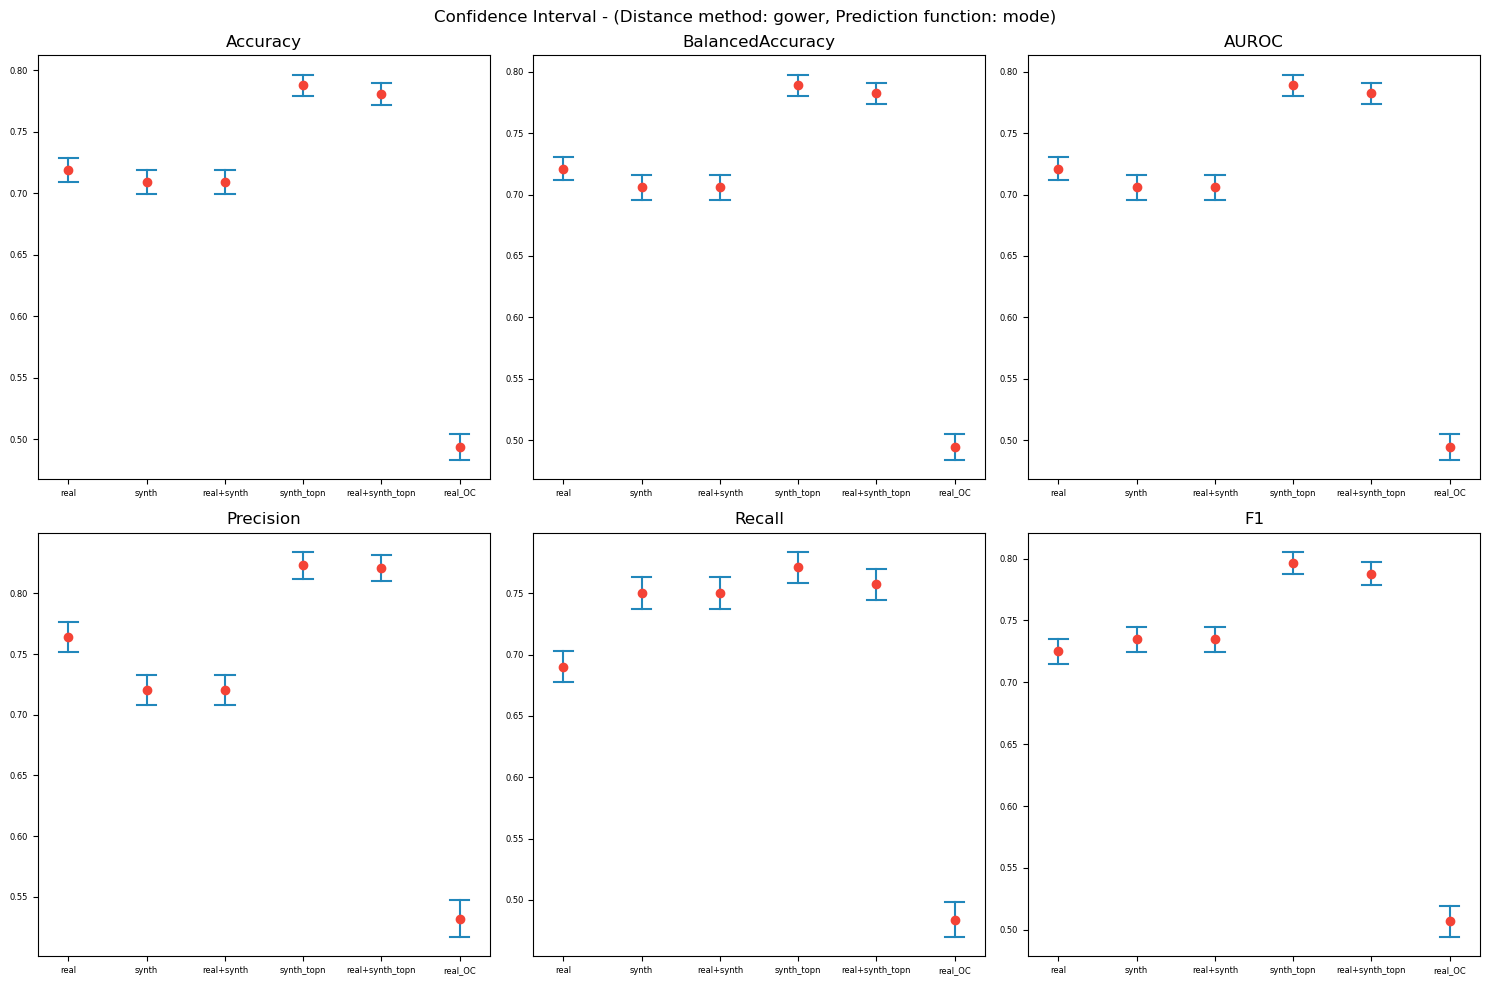

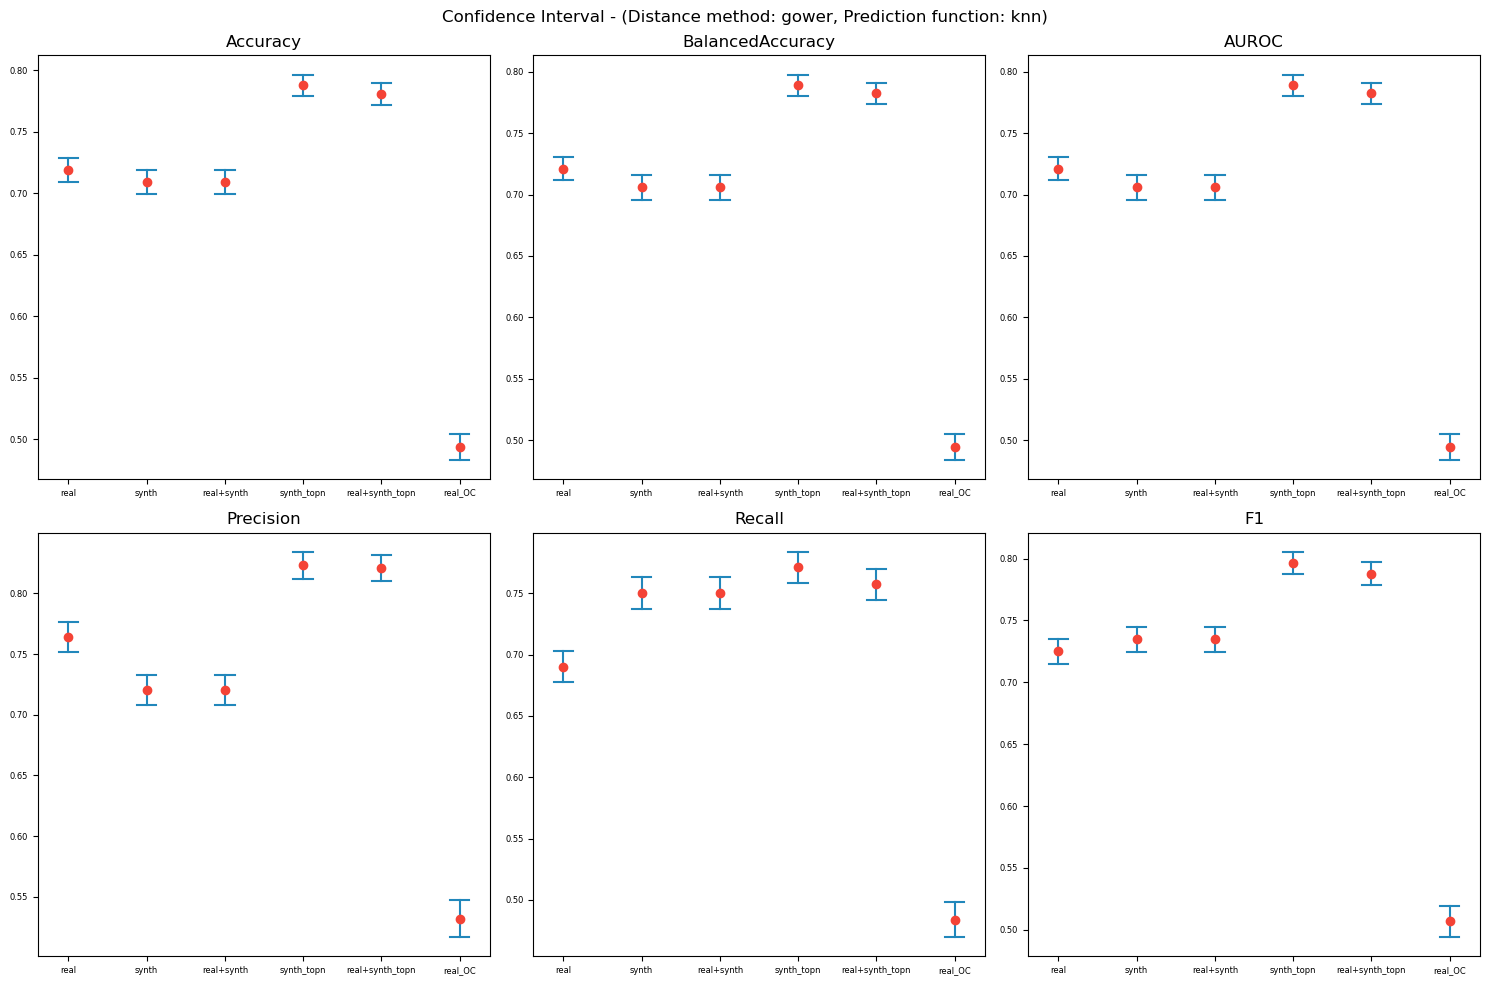

In [7]:
method ='gower'

import pandas as pd
performances_df = bootstrap_resample_90perc_performance(method) #or use performances_df=pd.read_csv(output_path+method+'_90perc_performances.csv')
ci_df = summarize_ci(performances_df, '90perc')
plot_ci_all(ci_df, '90perc')


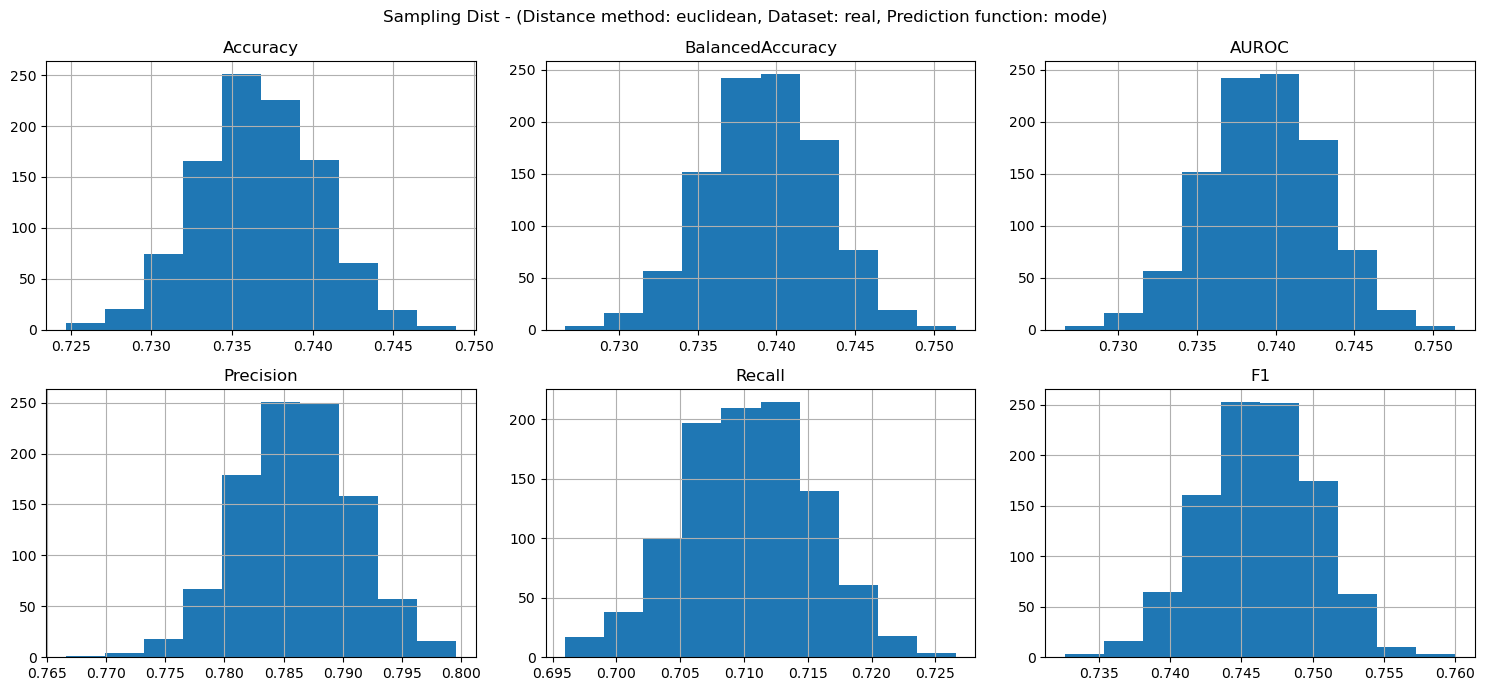

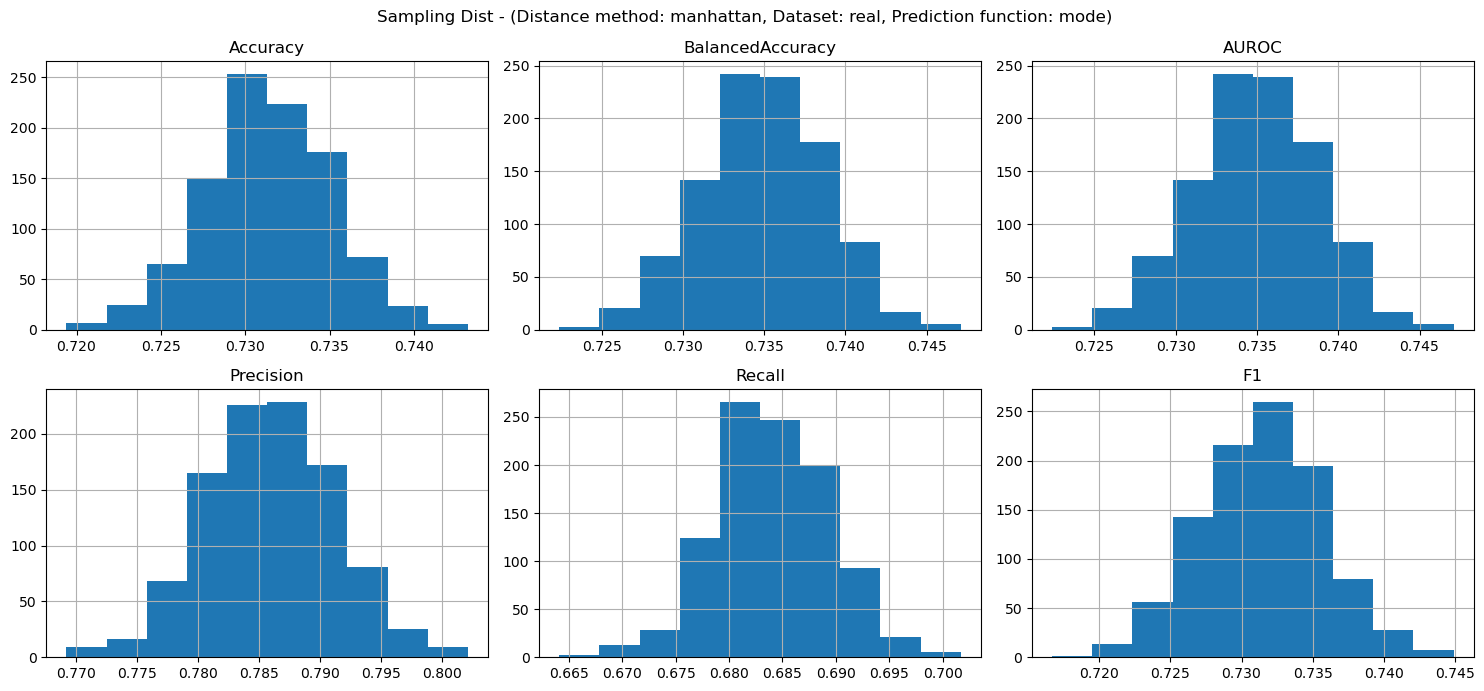

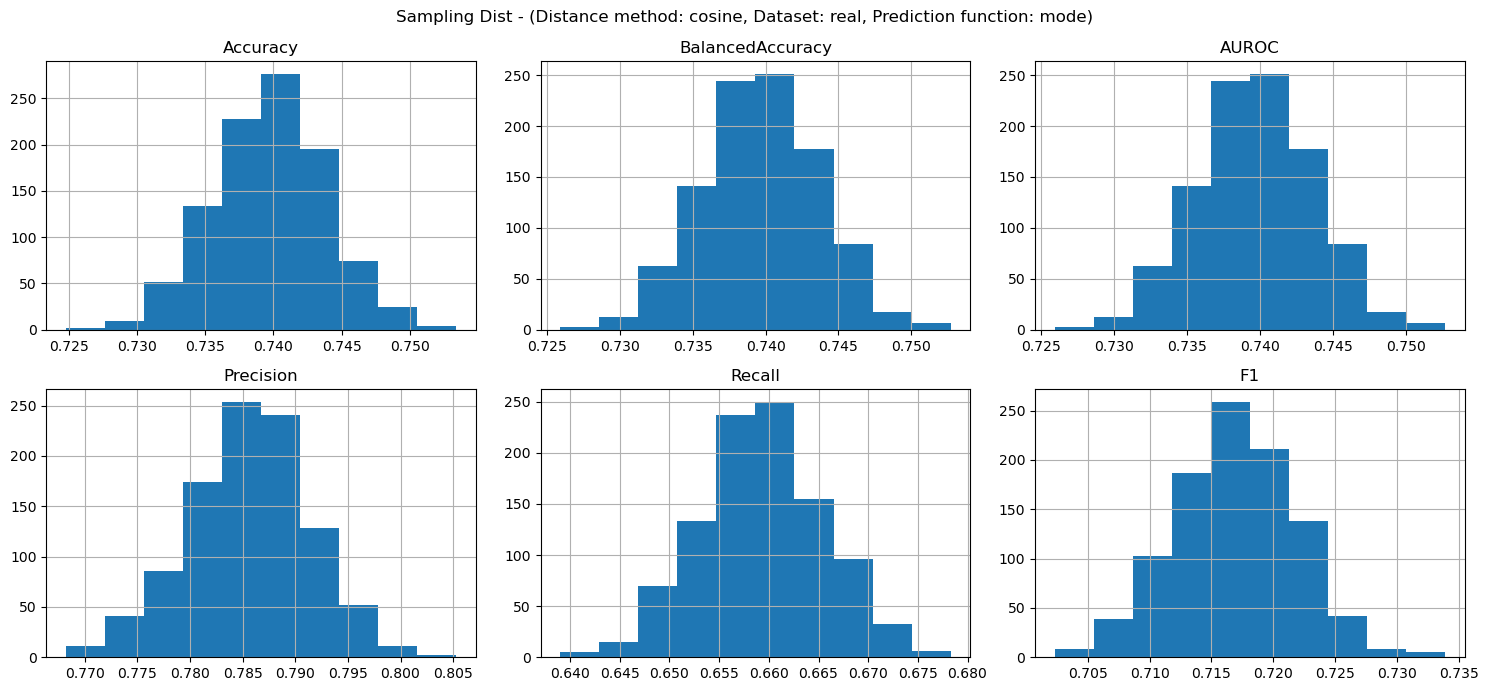

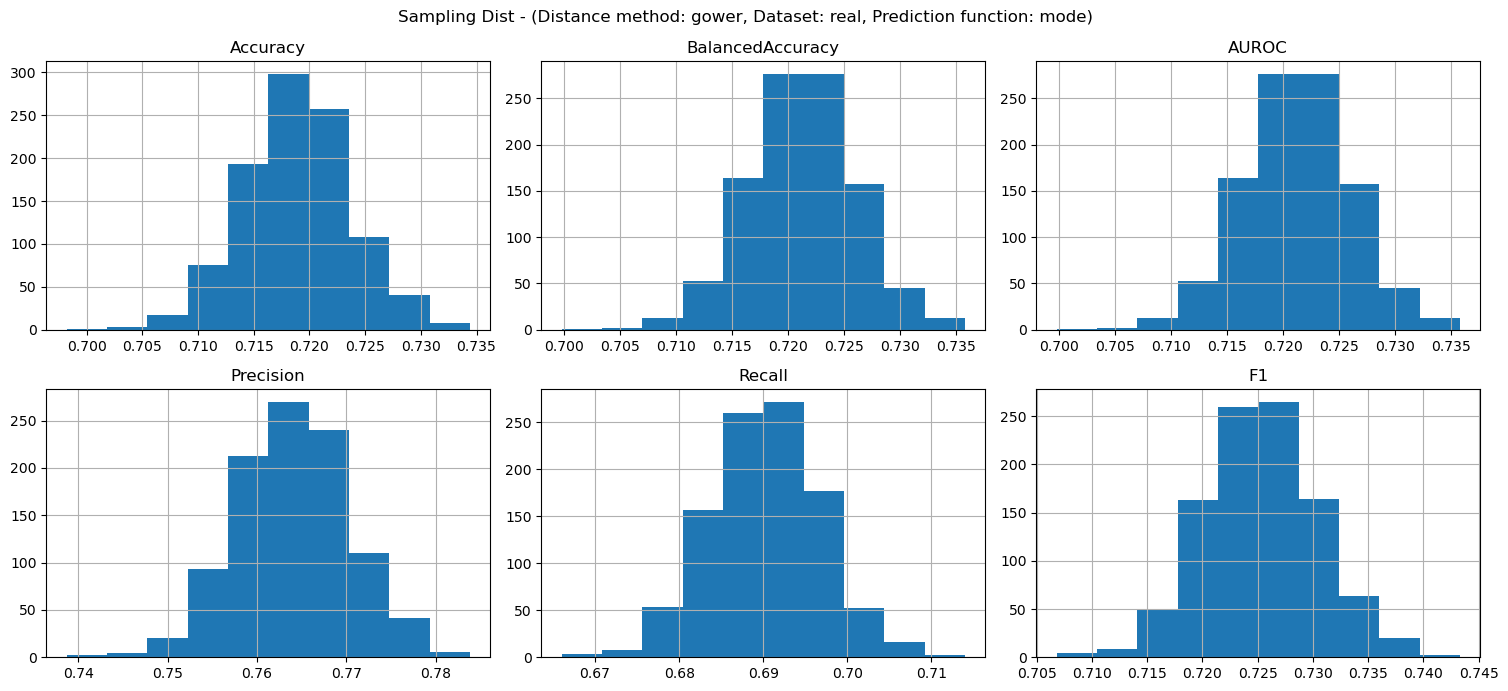

In [9]:
#show sample distpredict_function ='mode'
dataset = 'real'
predict_function ='mode'
method_list = ['euclidean','manhattan','cosine','gower']

import pandas as pd
for method in method_list:
    performances_df = pd.read_csv(output_path+method+'_90perc_performances.csv')
    show_metric_dist(performances_df, method, predict_function, dataset)